In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "100X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 2


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_100X-BREAKHIS-Dataset-60-10-30-VGGINet/2'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/100X/2'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1128 files belonging to 2 classes.


Found 187 files belonging to 2 classes.


Found 566 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2968 - accuracy: 0.5156

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 5.1715 - accuracy: 0.6289

3/9 [=========>....................] - ETA: 8s - loss: 5.4573 - accuracy: 0.6589

4/9 [============>.................] - ETA: 7s - loss: 4.9649 - accuracy: 0.6953

5/9 [===============>..............] - ETA: 7s - loss: 4.8230 - accuracy: 0.6953

6/9 [===================>..........] - ETA: 4s - loss: 5.1355 - accuracy: 0.6849

7/9 [======================>.......] - ETA: 3s - loss: 5.0826 - accuracy: 0.6908

8/9 [=========================>....] - ETA: 1s - loss: 4.9158 - accuracy: 0.7100

9/9 [==============================] - ETA: 0s - loss: 4.9213 - accuracy: 0.7181

9/9 [==============================] - 35s 4s/step - loss: 4.9213 - accuracy: 0.7181 - val_loss: 5.7277 - val_accuracy: 0.8663


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 4.3605 - accuracy: 0.8047

2/9 [=====>........................] - ETA: 14s - loss: 4.7750 - accuracy: 0.8203

3/9 [=========>....................] - ETA: 10s - loss: 4.0381 - accuracy: 0.8359

4/9 [============>.................] - ETA: 10s - loss: 3.4158 - accuracy: 0.8555

5/9 [===============>..............] - ETA: 7s - loss: 3.1608 - accuracy: 0.8609 

6/9 [===================>..........] - ETA: 5s - loss: 2.9096 - accuracy: 0.8659

7/9 [======================>.......] - ETA: 3s - loss: 2.9587 - accuracy: 0.8560

8/9 [=========================>....] - ETA: 1s - loss: 3.0584 - accuracy: 0.8516

9/9 [==============================] - ETA: 0s - loss: 3.2093 - accuracy: 0.8493

9/9 [==============================] - 16s 2s/step - loss: 3.2093 - accuracy: 0.8493 - val_loss: 1.7941 - val_accuracy: 0.9144


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 2.5099 - accuracy: 0.8125

2/9 [=====>........................] - ETA: 14s - loss: 3.1127 - accuracy: 0.7891

3/9 [=========>....................] - ETA: 10s - loss: 2.9151 - accuracy: 0.8021

4/9 [============>.................] - ETA: 10s - loss: 2.5830 - accuracy: 0.8281

5/9 [===============>..............] - ETA: 7s - loss: 2.4886 - accuracy: 0.8484 

6/9 [===================>..........] - ETA: 5s - loss: 2.5649 - accuracy: 0.8529

7/9 [======================>.......] - ETA: 3s - loss: 2.4713 - accuracy: 0.8594

8/9 [=========================>....] - ETA: 1s - loss: 2.4850 - accuracy: 0.8643

9/9 [==============================] - ETA: 0s - loss: 2.4581 - accuracy: 0.8670

9/9 [==============================] - 17s 2s/step - loss: 2.4581 - accuracy: 0.8670 - val_loss: 3.3396 - val_accuracy: 0.9037


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7915 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 3s - loss: 1.6563 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 7s - loss: 1.6510 - accuracy: 0.9141

4/9 [============>.................] - ETA: 6s - loss: 1.6767 - accuracy: 0.9082

5/9 [===============>..............] - ETA: 6s - loss: 1.4687 - accuracy: 0.9203

6/9 [===================>..........] - ETA: 5s - loss: 1.7103 - accuracy: 0.9010

7/9 [======================>.......] - ETA: 3s - loss: 1.7763 - accuracy: 0.8884

8/9 [=========================>....] - ETA: 1s - loss: 1.7460 - accuracy: 0.8896

9/9 [==============================] - ETA: 0s - loss: 1.7182 - accuracy: 0.8910

9/9 [==============================] - 16s 2s/step - loss: 1.7182 - accuracy: 0.8910 - val_loss: 2.2417 - val_accuracy: 0.9198


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 1.9487 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 11s - loss: 1.5880 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 8s - loss: 1.3571 - accuracy: 0.9062 

4/9 [============>.................] - ETA: 9s - loss: 1.4993 - accuracy: 0.9043

5/9 [===============>..............] - ETA: 6s - loss: 1.7554 - accuracy: 0.8984

6/9 [===================>..........] - ETA: 4s - loss: 1.6265 - accuracy: 0.9049

7/9 [======================>.......] - ETA: 3s - loss: 1.5901 - accuracy: 0.9051

8/9 [=========================>....] - ETA: 1s - loss: 1.5614 - accuracy: 0.9033

9/9 [==============================] - ETA: 0s - loss: 1.4993 - accuracy: 0.9034

9/9 [==============================] - 16s 2s/step - loss: 1.4993 - accuracy: 0.9034 - val_loss: 1.5241 - val_accuracy: 0.9305


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7168 - accuracy: 0.8672

2/9 [=====>........................] - ETA: 13s - loss: 1.4574 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 10s - loss: 1.2645 - accuracy: 0.8906

4/9 [============>.................] - ETA: 10s - loss: 1.1045 - accuracy: 0.9043

5/9 [===============>..............] - ETA: 7s - loss: 1.1315 - accuracy: 0.9047 

6/9 [===================>..........] - ETA: 5s - loss: 1.2555 - accuracy: 0.9023

7/9 [======================>.......] - ETA: 3s - loss: 1.2592 - accuracy: 0.9051

8/9 [=========================>....] - ETA: 1s - loss: 1.2622 - accuracy: 0.9053

9/9 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.9060

9/9 [==============================] - 17s 2s/step - loss: 1.2601 - accuracy: 0.9060 - val_loss: 0.6181 - val_accuracy: 0.9465


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4837 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 14s - loss: 1.0266 - accuracy: 0.8906

3/9 [=========>....................] - ETA: 10s - loss: 0.9337 - accuracy: 0.9062

4/9 [============>.................] - ETA: 10s - loss: 0.8975 - accuracy: 0.9121

5/9 [===============>..............] - ETA: 7s - loss: 0.8766 - accuracy: 0.9109 

6/9 [===================>..........] - ETA: 5s - loss: 1.0960 - accuracy: 0.8971

7/9 [======================>.......] - ETA: 3s - loss: 0.9987 - accuracy: 0.9029

8/9 [=========================>....] - ETA: 1s - loss: 1.1010 - accuracy: 0.9004

9/9 [==============================] - ETA: 0s - loss: 1.0033 - accuracy: 0.9087

9/9 [==============================] - 17s 2s/step - loss: 1.0033 - accuracy: 0.9087 - val_loss: 0.7600 - val_accuracy: 0.9519


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9281 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.9692 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 17s - loss: 1.0181 - accuracy: 0.9271

4/9 [============>.................] - ETA: 12s - loss: 0.8782 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 8s - loss: 0.8771 - accuracy: 0.9375 

6/9 [===================>..........] - ETA: 5s - loss: 0.8155 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.8931 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.8554 - accuracy: 0.9346

9/9 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.9344

9/9 [==============================] - 18s 2s/step - loss: 0.8490 - accuracy: 0.9344 - val_loss: 0.8647 - val_accuracy: 0.9465


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6992 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.5233 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.8264 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.9174 - accuracy: 0.9160

5/9 [===============>..............] - ETA: 7s - loss: 0.9657 - accuracy: 0.9125 

6/9 [===================>..........] - ETA: 5s - loss: 0.9296 - accuracy: 0.9089

7/9 [======================>.......] - ETA: 3s - loss: 0.9412 - accuracy: 0.9118

8/9 [=========================>....] - ETA: 1s - loss: 0.9262 - accuracy: 0.9121

9/9 [==============================] - ETA: 0s - loss: 0.9015 - accuracy: 0.9122

9/9 [==============================] - 16s 2s/step - loss: 0.9015 - accuracy: 0.9122 - val_loss: 0.7773 - val_accuracy: 0.9572


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7487 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 11s - loss: 1.5733 - accuracy: 0.8945

3/9 [=========>....................] - ETA: 8s - loss: 1.4885 - accuracy: 0.8958 

4/9 [============>.................] - ETA: 9s - loss: 1.3678 - accuracy: 0.8945

5/9 [===============>..............] - ETA: 6s - loss: 1.2053 - accuracy: 0.9062

6/9 [===================>..........] - ETA: 4s - loss: 1.1817 - accuracy: 0.9089

7/9 [======================>.......] - ETA: 3s - loss: 1.1834 - accuracy: 0.9085

8/9 [=========================>....] - ETA: 1s - loss: 1.1174 - accuracy: 0.9111

9/9 [==============================] - ETA: 0s - loss: 1.0295 - accuracy: 0.9140

9/9 [==============================] - 16s 2s/step - loss: 1.0295 - accuracy: 0.9140 - val_loss: 0.6114 - val_accuracy: 0.9519


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5792 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.8883 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 9s - loss: 0.8607 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 10s - loss: 0.8326 - accuracy: 0.9199

5/9 [===============>..............] - ETA: 7s - loss: 0.7757 - accuracy: 0.9234 

6/9 [===================>..........] - ETA: 5s - loss: 0.8640 - accuracy: 0.9232

7/9 [======================>.......] - ETA: 3s - loss: 0.9480 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.9515 - accuracy: 0.9180

9/9 [==============================] - ETA: 0s - loss: 0.9265 - accuracy: 0.9184

9/9 [==============================] - 17s 2s/step - loss: 0.9265 - accuracy: 0.9184 - val_loss: 0.7125 - val_accuracy: 0.9572


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4538 - accuracy: 0.8672

2/9 [=====>........................] - ETA: 14s - loss: 1.1092 - accuracy: 0.9023

3/9 [=========>....................] - ETA: 10s - loss: 1.0507 - accuracy: 0.9010

4/9 [============>.................] - ETA: 10s - loss: 1.1121 - accuracy: 0.9023

5/9 [===============>..............] - ETA: 7s - loss: 1.0793 - accuracy: 0.9062 

6/9 [===================>..........] - ETA: 5s - loss: 0.9892 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 0.9708 - accuracy: 0.9129

8/9 [=========================>....] - ETA: 1s - loss: 0.9555 - accuracy: 0.9131

9/9 [==============================] - ETA: 0s - loss: 0.9616 - accuracy: 0.9131

9/9 [==============================] - 17s 2s/step - loss: 0.9616 - accuracy: 0.9131 - val_loss: 1.0074 - val_accuracy: 0.9412


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6503 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.5357 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.5134 - accuracy: 0.9453

4/9 [============>.................] - ETA: 9s - loss: 0.4529 - accuracy: 0.9434 

5/9 [===============>..............] - ETA: 8s - loss: 0.4742 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 5s - loss: 0.5886 - accuracy: 0.9297

7/9 [======================>.......] - ETA: 3s - loss: 0.5681 - accuracy: 0.9319

8/9 [=========================>....] - ETA: 1s - loss: 0.5813 - accuracy: 0.9336

9/9 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.9300

9/9 [==============================] - 17s 2s/step - loss: 0.6620 - accuracy: 0.9300 - val_loss: 0.6465 - val_accuracy: 0.9572


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9721 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 3s - loss: 1.4976 - accuracy: 0.8594

3/9 [=========>....................] - ETA: 3s - loss: 1.1983 - accuracy: 0.8854

4/9 [============>.................] - ETA: 7s - loss: 1.1778 - accuracy: 0.9023

5/9 [===============>..............] - ETA: 6s - loss: 1.1172 - accuracy: 0.9062

6/9 [===================>..........] - ETA: 4s - loss: 1.1165 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 1.1813 - accuracy: 0.9029

8/9 [=========================>....] - ETA: 1s - loss: 1.1492 - accuracy: 0.9033

9/9 [==============================] - ETA: 0s - loss: 1.0931 - accuracy: 0.9069

9/9 [==============================] - 16s 2s/step - loss: 1.0931 - accuracy: 0.9069 - val_loss: 0.7914 - val_accuracy: 0.9465


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2445 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.8020 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.6486 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 10s - loss: 0.5877 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.7748 - accuracy: 0.9344 

6/9 [===================>..........] - ETA: 5s - loss: 0.7929 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.8088 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.8318 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.8021 - accuracy: 0.9300

9/9 [==============================] - 17s 2s/step - loss: 0.8021 - accuracy: 0.9300 - val_loss: 1.3160 - val_accuracy: 0.9305


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1953 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 10s - loss: 0.3561 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 8s - loss: 0.6759 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 8s - loss: 0.8659 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 0.8257 - accuracy: 0.9344

6/9 [===================>..........] - ETA: 4s - loss: 0.8254 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.7808 - accuracy: 0.9330

8/9 [=========================>....] - ETA: 1s - loss: 0.7187 - accuracy: 0.9346

9/9 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.9353

9/9 [==============================] - 16s 2s/step - loss: 0.7120 - accuracy: 0.9353 - val_loss: 1.3850 - val_accuracy: 0.9465


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3904 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 12s - loss: 1.0548 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 1.0540 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 9s - loss: 0.9812 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.9114 - accuracy: 0.9281

6/9 [===================>..........] - ETA: 5s - loss: 0.8685 - accuracy: 0.9297

7/9 [======================>.......] - ETA: 3s - loss: 0.9025 - accuracy: 0.9297

8/9 [=========================>....] - ETA: 1s - loss: 0.9545 - accuracy: 0.9268

9/9 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.9309

9/9 [==============================] - 16s 2s/step - loss: 0.8875 - accuracy: 0.9309 - val_loss: 1.0888 - val_accuracy: 0.9251


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7092 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.8931 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.6964 - accuracy: 0.9401

4/9 [============>.................] - ETA: 10s - loss: 0.7930 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.8074 - accuracy: 0.9281 

6/9 [===================>..........] - ETA: 5s - loss: 0.8490 - accuracy: 0.9232

7/9 [======================>.......] - ETA: 3s - loss: 0.8375 - accuracy: 0.9208

8/9 [=========================>....] - ETA: 1s - loss: 0.7583 - accuracy: 0.9258

9/9 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.9309

9/9 [==============================] - 17s 2s/step - loss: 0.7536 - accuracy: 0.9309 - val_loss: 0.5531 - val_accuracy: 0.9626


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3211 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4055 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.7188 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.7024 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.8450 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 4s - loss: 0.7843 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.9403 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.8844 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.8127 - accuracy: 0.9468

9/9 [==============================] - 16s 2s/step - loss: 0.8127 - accuracy: 0.9468 - val_loss: 0.9263 - val_accuracy: 0.9412


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3275 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 10s - loss: 0.6767 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 8s - loss: 0.6309 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.6542 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 0.6969 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 4s - loss: 0.6948 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.7399 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.7264 - accuracy: 0.9316

9/9 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.9353

9/9 [==============================] - 16s 2s/step - loss: 0.6802 - accuracy: 0.9353 - val_loss: 0.7677 - val_accuracy: 0.9519


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0465 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.9170 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.7891 - accuracy: 0.9427

4/9 [============>.................] - ETA: 8s - loss: 0.6969 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.7881 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 4s - loss: 0.7169 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.6387 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.6290 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.9477

9/9 [==============================] - 16s 2s/step - loss: 0.6161 - accuracy: 0.9477 - val_loss: 0.6021 - val_accuracy: 0.9626


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4583 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.5102 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.6500 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 9s - loss: 0.6789 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 0.7440 - accuracy: 0.9375

6/9 [===================>..........] - ETA: 4s - loss: 0.8698 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.7679 - accuracy: 0.9397

8/9 [=========================>....] - ETA: 1s - loss: 0.7438 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.9424

9/9 [==============================] - 16s 2s/step - loss: 0.6780 - accuracy: 0.9424 - val_loss: 1.4651 - val_accuracy: 0.9412


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4800 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.6504 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 8s - loss: 0.6330 - accuracy: 0.9505

4/9 [============>.................] - ETA: 10s - loss: 0.5854 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.5723 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.6407 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.6099 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.6077 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.9504

9/9 [==============================] - 16s 2s/step - loss: 0.6700 - accuracy: 0.9504 - val_loss: 0.2649 - val_accuracy: 0.9465


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6543 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5472 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.4642 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 10s - loss: 0.4473 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.4190 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.4595 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4626 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.4729 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.9628

9/9 [==============================] - 16s 2s/step - loss: 0.4294 - accuracy: 0.9628 - val_loss: 0.3928 - val_accuracy: 0.9679


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 10s - loss: 0.4308 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.7949 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 8s - loss: 0.6426 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 6s - loss: 0.5681 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 4s - loss: 0.5611 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 2s - loss: 0.5344 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.5705 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.9530

9/9 [==============================] - 15s 2s/step - loss: 0.5733 - accuracy: 0.9530 - val_loss: 0.8283 - val_accuracy: 0.9465


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5863 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 0.5414 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 10s - loss: 0.4439 - accuracy: 0.9505

4/9 [============>.................] - ETA: 9s - loss: 0.6119 - accuracy: 0.9453 

5/9 [===============>..............] - ETA: 7s - loss: 0.5579 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 5s - loss: 0.5775 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.5825 - accuracy: 0.9464

8/9 [=========================>....] - ETA: 1s - loss: 0.5604 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.9477

9/9 [==============================] - 17s 2s/step - loss: 0.5456 - accuracy: 0.9477 - val_loss: 0.4902 - val_accuracy: 0.9626


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6084 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.6298 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.5217 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 0.5725 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.5995 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 4s - loss: 0.6094 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5622 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5447 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.9530

9/9 [==============================] - 16s 2s/step - loss: 0.5351 - accuracy: 0.9530 - val_loss: 0.8766 - val_accuracy: 0.9519


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8984 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.8369 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 7s - loss: 0.9036 - accuracy: 0.9453

4/9 [============>.................] - ETA: 6s - loss: 0.9266 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 6s - loss: 0.8650 - accuracy: 0.9453

6/9 [===================>..........] - ETA: 4s - loss: 0.7664 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.6609 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.6408 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.9539

9/9 [==============================] - 16s 2s/step - loss: 0.6425 - accuracy: 0.9539 - val_loss: 0.6924 - val_accuracy: 0.9519


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1056 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4290 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.5320 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 9s - loss: 0.5717 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.5375 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 4s - loss: 0.5465 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5467 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5457 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.9504

9/9 [==============================] - 16s 2s/step - loss: 0.5145 - accuracy: 0.9504 - val_loss: 1.1793 - val_accuracy: 0.9465


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0198 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.4744 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.4444 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4321 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 4s - loss: 0.4325 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.4161 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.4640 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.9566

9/9 [==============================] - 16s 2s/step - loss: 0.4421 - accuracy: 0.9566 - val_loss: 1.0263 - val_accuracy: 0.9465


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3982 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.3482 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.4067 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.3051 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 8s - loss: 0.2484 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3329 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3444 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3715 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.9690

9/9 [==============================] - 17s 2s/step - loss: 0.3902 - accuracy: 0.9690 - val_loss: 0.9955 - val_accuracy: 0.9465


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7701 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.5707 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.5446 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 10s - loss: 0.5247 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.5604 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.4913 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5827 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.5350 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.9645

9/9 [==============================] - 17s 2s/step - loss: 0.4918 - accuracy: 0.9645 - val_loss: 1.3581 - val_accuracy: 0.9305


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5502 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5444 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.6474 - accuracy: 0.9557

4/9 [============>.................] - ETA: 9s - loss: 0.6046 - accuracy: 0.9590 

5/9 [===============>..............] - ETA: 7s - loss: 0.6114 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.6232 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.6228 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.5600 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.9637

9/9 [==============================] - 16s 2s/step - loss: 0.5104 - accuracy: 0.9637 - val_loss: 0.9104 - val_accuracy: 0.9519


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2678 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3257 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.3802 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.4627 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.3880 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.3698 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.3561 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.4783 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.9583

9/9 [==============================] - 16s 2s/step - loss: 0.4907 - accuracy: 0.9583 - val_loss: 0.8629 - val_accuracy: 0.9572


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4151 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.5663 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.5301 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.4777 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4712 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.5141 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.5301 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.4821 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.9601

9/9 [==============================] - 16s 2s/step - loss: 0.4701 - accuracy: 0.9601 - val_loss: 1.7089 - val_accuracy: 0.9412


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4133 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.6208 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.7681 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.5875 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.6262 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 4s - loss: 0.6756 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.6033 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5439 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.9583

9/9 [==============================] - 16s 2s/step - loss: 0.5555 - accuracy: 0.9583 - val_loss: 1.2626 - val_accuracy: 0.9465


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3269 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3442 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.2915 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3160 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4512 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.4728 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.5205 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4992 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.9628

9/9 [==============================] - 16s 2s/step - loss: 0.4745 - accuracy: 0.9628 - val_loss: 0.9618 - val_accuracy: 0.9412


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2625 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4152 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.3230 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 10s - loss: 0.2573 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3286 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 4s - loss: 0.3832 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.3548 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3272 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.9707

9/9 [==============================] - 16s 2s/step - loss: 0.3160 - accuracy: 0.9707 - val_loss: 0.5694 - val_accuracy: 0.9679


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0652 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.6212 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.4145 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.4289 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.5758 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.5644 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.7419 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.6715 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.6329 - accuracy: 0.9592

9/9 [==============================] - 16s 2s/step - loss: 0.6329 - accuracy: 0.9592 - val_loss: 0.7771 - val_accuracy: 0.9626


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5327 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5162 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 16s - loss: 0.4019 - accuracy: 0.9609

4/9 [============>.................] - ETA: 11s - loss: 0.3749 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4048 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.4417 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.3831 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4429 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.9637

9/9 [==============================] - 17s 2s/step - loss: 0.4153 - accuracy: 0.9637 - val_loss: 1.1486 - val_accuracy: 0.9305


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6727 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3427 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.4377 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 10s - loss: 0.3546 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3472 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.4156 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4652 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5005 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.5255 - accuracy: 0.9672 - val_loss: 0.2788 - val_accuracy: 0.9679


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3829 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 10s - loss: 0.3731 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.5100 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 8s - loss: 0.4988 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4480 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.4525 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3964 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3855 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9699

9/9 [==============================] - 17s 2s/step - loss: 0.3563 - accuracy: 0.9699 - val_loss: 0.8004 - val_accuracy: 0.9519


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6347 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.5319 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.4889 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 0.4379 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.4817 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 5s - loss: 0.4519 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4442 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5099 - accuracy: 0.9580

9/9 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.9574

9/9 [==============================] - 17s 2s/step - loss: 0.5207 - accuracy: 0.9574 - val_loss: 0.6518 - val_accuracy: 0.9465


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4496 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.2401 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2634 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.3399 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4389 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 5s - loss: 0.4116 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4345 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.4039 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 0.9628

9/9 [==============================] - 16s 2s/step - loss: 0.3999 - accuracy: 0.9628 - val_loss: 0.7945 - val_accuracy: 0.9358


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4300 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2190 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.2870 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2985 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3887 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3930 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.3585 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3328 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.9707

9/9 [==============================] - 17s 2s/step - loss: 0.3780 - accuracy: 0.9707 - val_loss: 0.9172 - val_accuracy: 0.9305


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1942 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3534 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 15s - loss: 0.5731 - accuracy: 0.9557

4/9 [============>.................] - ETA: 13s - loss: 0.4791 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 9s - loss: 0.5299 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 6s - loss: 0.5566 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 4s - loss: 0.5421 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.6209 - accuracy: 0.9561

9/9 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.9583

9/9 [==============================] - 19s 2s/step - loss: 0.5872 - accuracy: 0.9583 - val_loss: 0.7663 - val_accuracy: 0.9519


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0512 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1368 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1451 - accuracy: 0.9805 

5/9 [===============>..............] - ETA: 7s - loss: 0.2956 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.3188 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3779 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3667 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.9725

9/9 [==============================] - 16s 2s/step - loss: 0.3588 - accuracy: 0.9725 - val_loss: 0.5949 - val_accuracy: 0.9572


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2884 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2926 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3614 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.3167 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2799 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.2378 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2088 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.1891 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9823

9/9 [==============================] - 16s 2s/step - loss: 0.1726 - accuracy: 0.9823 - val_loss: 0.8861 - val_accuracy: 0.9519


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4238 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4849 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.3808 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.4316 - accuracy: 0.9648 

5/9 [===============>..............] - ETA: 7s - loss: 0.4352 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 5s - loss: 0.4784 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.4132 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3639 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.9725

9/9 [==============================] - 16s 2s/step - loss: 0.3428 - accuracy: 0.9725 - val_loss: 0.7927 - val_accuracy: 0.9305


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2802 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 11s - loss: 0.2502 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.4111 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.3309 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.2765 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.2701 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 2s - loss: 0.2432 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2849 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.9787

9/9 [==============================] - 15s 2s/step - loss: 0.2638 - accuracy: 0.9787 - val_loss: 0.3905 - val_accuracy: 0.9626


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1392 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1482 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.0990 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1690 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2317 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2263 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2192 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2054 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9823

9/9 [==============================] - 16s 2s/step - loss: 0.1983 - accuracy: 0.9823 - val_loss: 0.1565 - val_accuracy: 0.9840


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1909 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 10s - loss: 0.1719 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.1695 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.1514 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1855 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.2298 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2083 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.1975 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.1967 - accuracy: 0.9778 - val_loss: 0.1016 - val_accuracy: 0.9893


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1342 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3474 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2921 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.2786 - accuracy: 0.9766 

5/9 [===============>..............] - ETA: 7s - loss: 0.2828 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.2455 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2211 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.1955 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.1916 - accuracy: 0.9796 - val_loss: 0.2949 - val_accuracy: 0.9679


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3562 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2190 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1907 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3183 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2750 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2471 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2173 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2207 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.2347 - accuracy: 0.9796 - val_loss: 0.4255 - val_accuracy: 0.9733


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6385 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 16s - loss: 0.3269 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 11s - loss: 0.2927 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.3553 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3690 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3668 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3205 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.2914 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9734

9/9 [==============================] - 16s 2s/step - loss: 0.2711 - accuracy: 0.9734 - val_loss: 0.6395 - val_accuracy: 0.9679


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 9s - loss: 0.2100 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.3925 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4323 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3628 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3147 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3028 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.9743

9/9 [==============================] - 16s 2s/step - loss: 0.3470 - accuracy: 0.9743 - val_loss: 0.9794 - val_accuracy: 0.9572


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5847 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.4423 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.3737 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.4415 - accuracy: 0.9668 

5/9 [===============>..............] - ETA: 7s - loss: 0.3765 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.3850 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3520 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3547 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.9707

9/9 [==============================] - 16s 2s/step - loss: 0.3456 - accuracy: 0.9707 - val_loss: 1.4724 - val_accuracy: 0.9519


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3124 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3431 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2872 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.2623 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.3087 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 4s - loss: 0.4842 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4332 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.4937 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.4542 - accuracy: 0.9699 - val_loss: 0.7320 - val_accuracy: 0.9626


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1088 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.2070 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.3090 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3047 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2667 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2511 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2241 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2583 - accuracy: 0.9805 - val_loss: 1.0197 - val_accuracy: 0.9679


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3796 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.3698 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.3320 - accuracy: 0.9583

4/9 [============>.................] - ETA: 9s - loss: 0.2838 - accuracy: 0.9648 

5/9 [===============>..............] - ETA: 7s - loss: 0.2456 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.2569 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.2781 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.2434 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.2241 - accuracy: 0.9752 - val_loss: 0.8947 - val_accuracy: 0.9626


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1642 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2642 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3535 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.3618 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3201 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2951 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2848 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2957 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.9743

9/9 [==============================] - 17s 2s/step - loss: 0.2740 - accuracy: 0.9743 - val_loss: 0.8830 - val_accuracy: 0.9465


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7459 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5452 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.6017 - accuracy: 0.9609

4/9 [============>.................] - ETA: 9s - loss: 0.6384 - accuracy: 0.9609 

5/9 [===============>..............] - ETA: 7s - loss: 0.6355 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.6459 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.6497 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.5731 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.9654

9/9 [==============================] - 16s 2s/step - loss: 0.5420 - accuracy: 0.9654 - val_loss: 0.6105 - val_accuracy: 0.9733


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1200 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.5237 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.4915 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.4660 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3879 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.4254 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.4432 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4384 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.9743

9/9 [==============================] - 17s 2s/step - loss: 0.4782 - accuracy: 0.9743 - val_loss: 1.6968 - val_accuracy: 0.9251


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1616 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2692 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 15s - loss: 0.3251 - accuracy: 0.9740

4/9 [============>.................] - ETA: 11s - loss: 0.3534 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4193 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3932 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3816 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3794 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.9734

9/9 [==============================] - 17s 2s/step - loss: 0.3644 - accuracy: 0.9734 - val_loss: 0.9576 - val_accuracy: 0.9626


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8656 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.4621 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3984 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.3019 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3666 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.3420 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.4149 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3735 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.4086 - accuracy: 0.9778 - val_loss: 0.9053 - val_accuracy: 0.9465


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3954 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 10s - loss: 0.4167 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.3128 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 8s - loss: 0.3896 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 6s - loss: 0.3118 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 4s - loss: 0.3634 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 2s - loss: 0.4627 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4106 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.9725

9/9 [==============================] - 15s 2s/step - loss: 0.3967 - accuracy: 0.9725 - val_loss: 0.8300 - val_accuracy: 0.9626


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3844 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 12s - loss: 0.2787 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.1927 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.1956 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 6s - loss: 0.2352 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.2039 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 2s - loss: 0.2862 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2700 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.9805

9/9 [==============================] - 15s 2s/step - loss: 0.2841 - accuracy: 0.9805 - val_loss: 0.3689 - val_accuracy: 0.9679


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3562 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 10s - loss: 0.6032 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.5594 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 8s - loss: 0.4196 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 6s - loss: 0.3470 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.3872 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 2s - loss: 0.4804 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4931 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.9690

9/9 [==============================] - 15s 2s/step - loss: 0.4591 - accuracy: 0.9690 - val_loss: 0.5922 - val_accuracy: 0.9626


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1186 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.5795 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.4827 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.5073 - accuracy: 0.9668 

5/9 [===============>..............] - ETA: 7s - loss: 0.4915 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 4s - loss: 0.4355 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4055 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4643 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.9645

9/9 [==============================] - 16s 2s/step - loss: 0.4712 - accuracy: 0.9645 - val_loss: 0.9887 - val_accuracy: 0.9572


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6667 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.4729 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.4445 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.3574 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3338 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.3744 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3685 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3549 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.3301 - accuracy: 0.9761 - val_loss: 0.4445 - val_accuracy: 0.9572


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2131e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.1653 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 9s - loss: 0.2263 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.2126 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1878 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.1690 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2682 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.2793 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2713 - accuracy: 0.9805 - val_loss: 0.8329 - val_accuracy: 0.9465


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2377 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.4732 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3814 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.3708 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.2967 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.2506 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2369 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2631 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9849

9/9 [==============================] - 16s 2s/step - loss: 0.2679 - accuracy: 0.9849 - val_loss: 0.8784 - val_accuracy: 0.9626


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1030 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.2785 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.3058 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3803 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 6s - loss: 0.3840 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 4s - loss: 0.3827 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3580 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3616 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.9707

9/9 [==============================] - 16s 2s/step - loss: 0.3696 - accuracy: 0.9707 - val_loss: 0.5240 - val_accuracy: 0.9786


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0616e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0396 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.0277 - accuracy: 0.9974

4/9 [============>.................] - ETA: 9s - loss: 0.0932 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.0922 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.0854 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.0898 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.0817 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9876

9/9 [==============================] - 16s 2s/step - loss: 0.1055 - accuracy: 0.9876 - val_loss: 0.9183 - val_accuracy: 0.9626


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2537 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 4s - loss: 0.7276 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.6551 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.5863 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.5112 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.4487 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.4240 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4019 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.9752

9/9 [==============================] - 17s 2s/step - loss: 0.3836 - accuracy: 0.9752 - val_loss: 0.3440 - val_accuracy: 0.9786


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2856 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1567 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1287 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.1268 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1258 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.1086 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1046 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1018 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9858

9/9 [==============================] - 16s 2s/step - loss: 0.1435 - accuracy: 0.9858 - val_loss: 0.4272 - val_accuracy: 0.9679


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5448 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.7627 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.6648 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.5400 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4526 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3775 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3451 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3779 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.9840

9/9 [==============================] - 16s 2s/step - loss: 0.3431 - accuracy: 0.9840 - val_loss: 0.6258 - val_accuracy: 0.9519


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.0062 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 9s - loss: 0.1178 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.2454 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3175 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.2646 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2684 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2349 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2252 - accuracy: 0.9805 - val_loss: 0.3152 - val_accuracy: 0.9733


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4703 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3779 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.4298 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.4019 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3881 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.4159 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3914 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3745 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.3745 - accuracy: 0.9752 - val_loss: 0.1026 - val_accuracy: 0.9840


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2373 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2287 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3655 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.2981 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.5770 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.6391 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.5559 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.5214 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.9770

9/9 [==============================] - 17s 2s/step - loss: 0.4815 - accuracy: 0.9770 - val_loss: 0.6738 - val_accuracy: 0.9679


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 3.7248e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.2831 - accuracy: 0.9766   

3/9 [=========>....................] - ETA: 9s - loss: 0.2939 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.3322 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3064 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.2934 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2876 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2517 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9840

9/9 [==============================] - 16s 2s/step - loss: 0.2722 - accuracy: 0.9840 - val_loss: 1.2913 - val_accuracy: 0.9572


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1217 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 15s - loss: 0.2296 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.1828 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2564 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2616 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2903 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2549 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.2327 - accuracy: 0.9796 - val_loss: 1.1306 - val_accuracy: 0.9519


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 2.1758e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.3614 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.2675 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.2746 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.2787 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.2952 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3496 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3089 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.3364 - accuracy: 0.9778 - val_loss: 0.6496 - val_accuracy: 0.9572


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1704 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0956 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.3547 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.3243 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3381 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.4437 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3803 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3367 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.3179 - accuracy: 0.9832 - val_loss: 0.5885 - val_accuracy: 0.9626


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1774 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 10s - loss: 0.2273 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2152 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 8s - loss: 0.2218 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.1775 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.2394 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 2s - loss: 0.2452 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2145 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9832

9/9 [==============================] - 15s 2s/step - loss: 0.2042 - accuracy: 0.9832 - val_loss: 0.7445 - val_accuracy: 0.9572


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2656 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.1747 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2211 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.1866 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1654 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.1535 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1505 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1851 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9823

9/9 [==============================] - 16s 2s/step - loss: 0.1700 - accuracy: 0.9823 - val_loss: 0.2223 - val_accuracy: 0.9786


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8444 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 3s - loss: 0.4838 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 7s - loss: 0.4340 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.3258 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.2681 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.2292 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2265 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2391 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9814

9/9 [==============================] - 15s 2s/step - loss: 0.2546 - accuracy: 0.9814 - val_loss: 0.3945 - val_accuracy: 0.9572


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1437 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1518 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.2468 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.2744 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.2426 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2691 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.2874 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.2643 - accuracy: 0.9796 - val_loss: 0.7801 - val_accuracy: 0.9572


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0367 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.1537 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.1038 - accuracy: 0.9922 

4/9 [============>.................] - ETA: 9s - loss: 0.1178 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1704 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.1685 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1836 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1695 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9858

9/9 [==============================] - 16s 2s/step - loss: 0.1538 - accuracy: 0.9858 - val_loss: 0.4204 - val_accuracy: 0.9786


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0483 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2604 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.4196 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 10s - loss: 0.4354 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4185 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3502 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3452 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3097 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3171 - accuracy: 0.9770 - val_loss: 0.4978 - val_accuracy: 0.9572


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0268 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.0466 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.0670 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.1245 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1790 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 4s - loss: 0.1885 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2345 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2327 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.2113 - accuracy: 0.9796 - val_loss: 0.7548 - val_accuracy: 0.9679


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1254 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.4213 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.4459 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4260 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3553 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3727 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3385 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.9796

9/9 [==============================] - 17s 2s/step - loss: 0.3159 - accuracy: 0.9796 - val_loss: 0.3903 - val_accuracy: 0.9840


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1616 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.6203 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.4135 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3143 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4157 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3598 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3109 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3106 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2822 - accuracy: 0.9805 - val_loss: 0.9377 - val_accuracy: 0.9626


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4399 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2200 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1626 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1694 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1502 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2449 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2432 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2128 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2884 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.2884 - accuracy: 0.9832 - val_loss: 0.6292 - val_accuracy: 0.9733


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3008 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.1504 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2165 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2009 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2164 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2477 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2316 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2112 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9787

9/9 [==============================] - 17s 2s/step - loss: 0.2151 - accuracy: 0.9787 - val_loss: 0.7147 - val_accuracy: 0.9733


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1082 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1022 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1094 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2361 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2362 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2046 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2618 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2313 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.2495 - accuracy: 0.9805 - val_loss: 1.2817 - val_accuracy: 0.9626


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1946 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3819 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4732 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.4815 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4737 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.5186 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4702 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4115 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.9778

9/9 [==============================] - 17s 2s/step - loss: 0.3768 - accuracy: 0.9778 - val_loss: 0.4357 - val_accuracy: 0.9679


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2074 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1215 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 8s - loss: 0.1926 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.4522 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4627 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.5077 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4390 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.4095 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3874 - accuracy: 0.9796 - val_loss: 0.6269 - val_accuracy: 0.9626


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1570 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1257 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0987 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1080 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1172 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.0998 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1465 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1282 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9876

9/9 [==============================] - 17s 2s/step - loss: 0.1220 - accuracy: 0.9876 - val_loss: 0.5524 - val_accuracy: 0.9572


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 1.8007e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.0037 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.0253 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.0971 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1200 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1818 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1581 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1871 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.2259 - accuracy: 0.9832 - val_loss: 0.4707 - val_accuracy: 0.9733


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

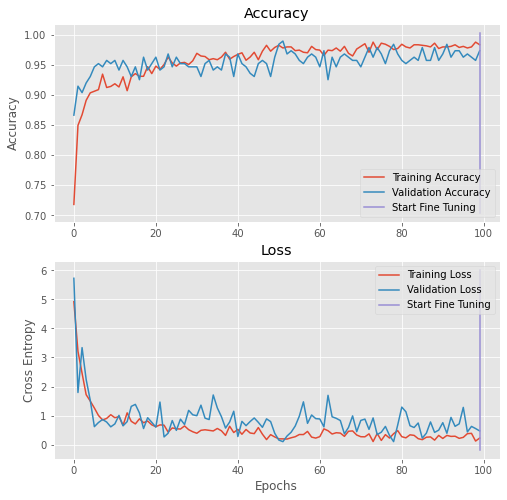

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.1944 - accuracy: 0.9688

2/5 [===========>..................] - ETA: 11s - loss: 1.3093 - accuracy: 0.9609

3/5 [=================>............] - ETA: 9s - loss: 1.1615 - accuracy: 0.9583 

4/5 [=======================>......] - ETA: 5s - loss: 1.1631 - accuracy: 0.9629

5/5 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.9611

5/5 [==============================] - 28s 6s/step - loss: 1.1281 - accuracy: 0.9611


[1.1280916929244995, 0.9611307382583618]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

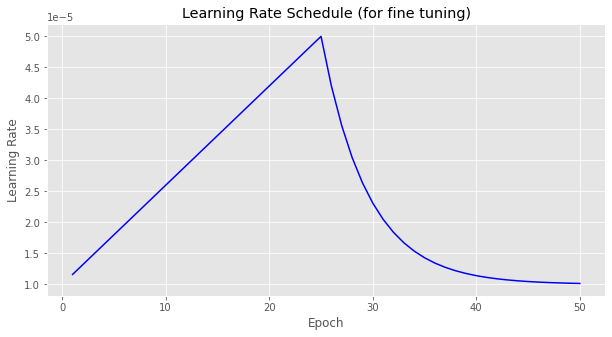

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1128 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 5s - loss: 0.0038 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 5s - loss: 0.4260 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 12s - loss: 0.3195 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 10s - loss: 0.2556 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.3314 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 13s - loss: 0.2840 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 12s - loss: 0.3328 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 11s - loss: 0.2983 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 10s - loss: 0.2692 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.4530 - accuracy: 0.9773 

12/18 [===================>..........] - ETA: 8s - loss: 0.4192 - accuracy: 0.9766

13/18 [====================>.........] - ETA: 7s - loss: 0.3974 - accuracy: 0.9772

14/18 [======================>.......] - ETA: 5s - loss: 0.3929 - accuracy: 0.9766

15/18 [========================>.....] - ETA: 3s - loss: 0.3667 - accuracy: 0.9781

16/18 [=========================>....] - ETA: 2s - loss: 0.4495 - accuracy: 0.9756

17/18 [===========================>..] - ETA: 1s - loss: 0.4674 - accuracy: 0.9752

18/18 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.9752

18/18 [==============================] - 28s 2s/step - loss: 0.4530 - accuracy: 0.9752 - val_loss: 0.4005 - val_accuracy: 0.9733



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/18 [>.............................] - ETA: 0s - loss: 1.3054 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 15s - loss: 0.6527 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 15s - loss: 0.4562 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 14s - loss: 0.4468 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 15s - loss: 0.4139 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 19s - loss: 0.5351 - accuracy: 0.9688

 7/18 [==========>...................] - ETA: 16s - loss: 0.5674 - accuracy: 0.9665

 8/18 [============>.................] - ETA: 14s - loss: 0.5677 - accuracy: 0.9688

 9/18 [==============>...............] - ETA: 13s - loss: 0.5444 - accuracy: 0.9670

10/18 [===============>..............] - ETA: 12s - loss: 0.6509 - accuracy: 0.9672

11/18 [=================>............] - ETA: 10s - loss: 0.6241 - accuracy: 0.9688

12/18 [===================>..........] - ETA: 8s - loss: 0.5721 - accuracy: 0.9714 

13/18 [====================>.........] - ETA: 7s - loss: 0.5425 - accuracy: 0.9712

14/18 [======================>.......] - ETA: 5s - loss: 0.5038 - accuracy: 0.9732

15/18 [========================>.....] - ETA: 4s - loss: 0.4798 - accuracy: 0.9740

16/18 [=========================>....] - ETA: 2s - loss: 0.4499 - accuracy: 0.9756

17/18 [===========================>..] - ETA: 1s - loss: 0.4601 - accuracy: 0.9733

18/18 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.9716

18/18 [==============================] - 25s 1s/step - loss: 0.5104 - accuracy: 0.9716 - val_loss: 0.3400 - val_accuracy: 0.9733



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 8s - loss: 0.2036 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 18s - loss: 0.1357 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.1018 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.0876 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 20s - loss: 0.3475 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 17s - loss: 0.4006 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 15s - loss: 0.3699 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 14s - loss: 0.3288 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 12s - loss: 0.4584 - accuracy: 0.9797

11/18 [=================>............] - ETA: 11s - loss: 0.4168 - accuracy: 0.9815

12/18 [===================>..........] - ETA: 8s - loss: 0.4013 - accuracy: 0.9818 

13/18 [====================>.........] - ETA: 7s - loss: 0.3779 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.3654 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 4s - loss: 0.3516 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.3296 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.3585 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.9814

18/18 [==============================] - 25s 1s/step - loss: 0.3645 - accuracy: 0.9814 - val_loss: 0.3337 - val_accuracy: 0.9733



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/18 [>.............................] - ETA: 0s - loss: 3.1623e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 8s - loss: 1.5812e-04 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 18s - loss: 0.0940 - accuracy: 0.9948   

 4/18 [=====>........................] - ETA: 17s - loss: 0.0705 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 18s - loss: 0.2914 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 17s - loss: 0.2868 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.2870 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 13s - loss: 0.2511 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 13s - loss: 0.2391 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 12s - loss: 0.3264 - accuracy: 0.9766

11/18 [=================>............] - ETA: 10s - loss: 0.2967 - accuracy: 0.9787

12/18 [===================>..........] - ETA: 8s - loss: 0.2724 - accuracy: 0.9805 

13/18 [====================>.........] - ETA: 7s - loss: 0.2514 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.2335 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 4s - loss: 0.2179 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.3220 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.3588 - accuracy: 0.9807

18/18 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.9805

18/18 [==============================] - 25s 1s/step - loss: 0.3879 - accuracy: 0.9805 - val_loss: 0.3225 - val_accuracy: 0.9733



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.0087 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 13s - loss: 0.0122 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.0530 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.1237 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.1980 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 12s - loss: 0.1732 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 12s - loss: 0.1540 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 10s - loss: 0.1645 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.1521 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 7s - loss: 0.1619 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.1516 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 4s - loss: 0.1592 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1567 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.1755 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.1968 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9823

18/18 [==============================] - 24s 1s/step - loss: 0.2077 - accuracy: 0.9823 - val_loss: 0.3067 - val_accuracy: 0.9733



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 7s - loss: 8.5597e-04 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 11s - loss: 5.7065e-04 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 12s - loss: 0.1379 - accuracy: 0.9922    

 5/18 [=======>......................] - ETA: 16s - loss: 0.2043 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 14s - loss: 0.1724 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 14s - loss: 0.3038 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 12s - loss: 0.2658 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2374 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.2138 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.2297 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 8s - loss: 0.2425 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2371 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2204 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.2233 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2508 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9849

18/18 [==============================] - 24s 1s/step - loss: 0.2635 - accuracy: 0.9849 - val_loss: 0.3013 - val_accuracy: 0.9733



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/18 [>.............................] - ETA: 0s - loss: 1.3514 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 4s - loss: 0.6757 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 7s - loss: 0.5338 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 6s - loss: 0.4466 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 13s - loss: 0.6330 - accuracy: 0.9688

 6/18 [=========>....................] - ETA: 11s - loss: 0.5275 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 13s - loss: 0.5855 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 12s - loss: 0.5123 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 10s - loss: 0.4999 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 9s - loss: 0.4950 - accuracy: 0.9797 

11/18 [=================>............] - ETA: 7s - loss: 0.4774 - accuracy: 0.9801

12/18 [===================>..........] - ETA: 6s - loss: 0.4377 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 5s - loss: 0.4040 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 4s - loss: 0.3778 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.3645 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.3673 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.3513 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.9832

18/18 [==============================] - 22s 1s/step - loss: 0.3389 - accuracy: 0.9832 - val_loss: 0.2855 - val_accuracy: 0.9733



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/18 [>.............................] - ETA: 0s - loss: 0.9794 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 10s - loss: 0.5842 - accuracy: 0.9609

 3/18 [====>.........................] - ETA: 26s - loss: 0.6395 - accuracy: 0.9635

 4/18 [=====>........................] - ETA: 20s - loss: 0.4797 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 19s - loss: 0.3891 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 16s - loss: 0.4211 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 17s - loss: 0.3609 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 14s - loss: 0.3351 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.3121 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.2809 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.2554 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 7s - loss: 0.2534 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 6s - loss: 0.2394 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.2223 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.1970 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.1972 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.1984 - accuracy: 0.9832 - val_loss: 0.2845 - val_accuracy: 0.9733



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/18 [>.............................] - ETA: 0s - loss: 1.6926 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 31s - loss: 0.8584 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 22s - loss: 0.6831 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 17s - loss: 0.5214 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 16s - loss: 0.4172 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 18s - loss: 0.3484 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.2987 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.2981 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.3265 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.2940 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.3348 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 7s - loss: 0.3069 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.3035 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.3080 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.2875 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.3196 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.3819 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.9805

18/18 [==============================] - 24s 1s/step - loss: 0.3684 - accuracy: 0.9805 - val_loss: 0.2964 - val_accuracy: 0.9786



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/18 [>.............................] - ETA: 0s - loss: 3.7565e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000    

 3/18 [====>.........................] - ETA: 11s - loss: 0.1605 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 12s - loss: 0.1419 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 15s - loss: 0.1135 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.0971 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 15s - loss: 0.1371 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 13s - loss: 0.1618 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.1880 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.1701 - accuracy: 0.9906

11/18 [=================>............] - ETA: 10s - loss: 0.2437 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 9s - loss: 0.2234 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 7s - loss: 0.2141 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1992 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.2338 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2442 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9840

18/18 [==============================] - 24s 1s/step - loss: 0.2369 - accuracy: 0.9840 - val_loss: 0.3118 - val_accuracy: 0.9786



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/18 [>.............................] - ETA: 0s - loss: 3.3112e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 12s - loss: 1.9289e-04 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 19s - loss: 0.2426 - accuracy: 0.9844    

 4/18 [=====>........................] - ETA: 15s - loss: 0.1994 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.1823 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 17s - loss: 0.1519 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.1302 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.1794 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.2272 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.2045 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.2423 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.2222 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2051 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1904 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.2790 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.3139 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2955 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.3192 - accuracy: 0.9867 - val_loss: 0.3093 - val_accuracy: 0.9786



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1581 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 5s - loss: 0.0791 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 19s - loss: 0.2232 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 15s - loss: 0.1674 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 16s - loss: 0.1728 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 14s - loss: 0.1441 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.1891 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 12s - loss: 0.1655 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1471 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 10s - loss: 0.2483 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2257 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.2763 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2679 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2670 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2492 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2372 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2280 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.2199 - accuracy: 0.9858 - val_loss: 0.3147 - val_accuracy: 0.9733



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/18 [>.............................] - ETA: 0s - loss: 3.8184e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 24s - loss: 1.9744e-07 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 18s - loss: 0.0379 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 15s - loss: 0.0859 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.0756 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 18s - loss: 0.1787 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.2918 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.3614 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.3216 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.3326 - accuracy: 0.9859

11/18 [=================>............] - ETA: 8s - loss: 0.3025 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.2774 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.2561 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 4s - loss: 0.2390 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.2625 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2477 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2332 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9867

18/18 [==============================] - 23s 1s/step - loss: 0.2445 - accuracy: 0.9867 - val_loss: 0.3187 - val_accuracy: 0.9786



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1825 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 12s - loss: 0.2667 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 16s - loss: 0.4837 - accuracy: 0.9583

 4/18 [=====>........................] - ETA: 15s - loss: 0.3628 - accuracy: 0.9688

 5/18 [=======>......................] - ETA: 18s - loss: 0.3772 - accuracy: 0.9719

 6/18 [=========>....................] - ETA: 15s - loss: 0.3151 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 14s - loss: 0.2887 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 13s - loss: 0.3089 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 12s - loss: 0.3385 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 11s - loss: 0.3772 - accuracy: 0.9750

11/18 [=================>............] - ETA: 9s - loss: 0.3440 - accuracy: 0.9759 

12/18 [===================>..........] - ETA: 7s - loss: 0.3456 - accuracy: 0.9766

13/18 [====================>.........] - ETA: 6s - loss: 0.3190 - accuracy: 0.9784

14/18 [======================>.......] - ETA: 5s - loss: 0.3121 - accuracy: 0.9788

15/18 [========================>.....] - ETA: 3s - loss: 0.3018 - accuracy: 0.9792

16/18 [=========================>....] - ETA: 2s - loss: 0.2830 - accuracy: 0.9805

17/18 [===========================>..] - ETA: 1s - loss: 0.2713 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.9805

18/18 [==============================] - 24s 1s/step - loss: 0.2617 - accuracy: 0.9805 - val_loss: 0.3257 - val_accuracy: 0.9786



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5270 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 11s - loss: 0.2635 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 17s - loss: 0.4134 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 18s - loss: 0.3115 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.3406 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 15s - loss: 0.2989 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.2920 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.2555 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.2509 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2590 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.2885 - accuracy: 0.9787 

12/18 [===================>..........] - ETA: 8s - loss: 0.3532 - accuracy: 0.9779

13/18 [====================>.........] - ETA: 6s - loss: 0.3375 - accuracy: 0.9784

14/18 [======================>.......] - ETA: 5s - loss: 0.3759 - accuracy: 0.9777

15/18 [========================>.....] - ETA: 3s - loss: 0.3607 - accuracy: 0.9781

16/18 [=========================>....] - ETA: 2s - loss: 0.3602 - accuracy: 0.9785

17/18 [===========================>..] - ETA: 1s - loss: 0.3393 - accuracy: 0.9798

18/18 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.9787

18/18 [==============================] - 25s 1s/step - loss: 0.3761 - accuracy: 0.9787 - val_loss: 0.3214 - val_accuracy: 0.9786



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 10s - loss: 0.0042 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 21s - loss: 0.0343 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 20s - loss: 0.1372 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 17s - loss: 0.1202 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 14s - loss: 0.1891 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.1852 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1774 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.2201 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2643 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 8s - loss: 0.2423 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2540 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2558 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2707 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2538 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.2836 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.9823

18/18 [==============================] - 24s 1s/step - loss: 0.2868 - accuracy: 0.9823 - val_loss: 0.3141 - val_accuracy: 0.9786



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/18 [>.............................] - ETA: 0s - loss: 6.2584e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 7.1268e-04 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 13s - loss: 0.0785 - accuracy: 0.9896   

 4/18 [=====>........................] - ETA: 17s - loss: 0.1262 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 14s - loss: 0.1010 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 18s - loss: 0.0842 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 16s - loss: 0.1878 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.1643 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 12s - loss: 0.1548 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1396 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.1269 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 8s - loss: 0.1427 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 6s - loss: 0.1377 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1283 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.1198 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.1126 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.1060 - accuracy: 0.9926

18/18 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9920

18/18 [==============================] - 24s 1s/step - loss: 0.1264 - accuracy: 0.9920 - val_loss: 0.3238 - val_accuracy: 0.9786



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/18 [>.............................] - ETA: 0s - loss: 5.0228e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 17s - loss: 0.0760 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 17s - loss: 0.3133 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 14s - loss: 0.3504 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 12s - loss: 0.2804 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 13s - loss: 0.3179 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 12s - loss: 0.3064 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 11s - loss: 0.2681 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 11s - loss: 0.2529 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 9s - loss: 0.2277 - accuracy: 0.9844 

11/18 [=================>............] - ETA: 8s - loss: 0.2268 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 7s - loss: 0.2095 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 5s - loss: 0.2051 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 4s - loss: 0.2225 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.2077 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2042 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2316 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9805

18/18 [==============================] - 22s 1s/step - loss: 0.2427 - accuracy: 0.9805 - val_loss: 0.3321 - val_accuracy: 0.9786



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0383 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 19s - loss: 0.0423 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.0888 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.0711 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.0592 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 14s - loss: 0.0508 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 13s - loss: 0.0445 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 12s - loss: 0.0396 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.0359 - accuracy: 0.9937

11/18 [=================>............] - ETA: 9s - loss: 0.0606 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 8s - loss: 0.0556 - accuracy: 0.9922

13/18 [====================>.........] - ETA: 7s - loss: 0.1034 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1036 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 4s - loss: 0.0999 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.0936 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.0947 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.0914 - accuracy: 0.9894 - val_loss: 0.3300 - val_accuracy: 0.9786



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4179 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.2100 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 15s - loss: 0.1400 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 15s - loss: 0.1505 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 16s - loss: 0.1204 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.1809 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 13s - loss: 0.2128 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 12s - loss: 0.1862 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 12s - loss: 0.1655 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 10s - loss: 0.1504 - accuracy: 0.9922

11/18 [=================>............] - ETA: 8s - loss: 0.1656 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 7s - loss: 0.1656 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 6s - loss: 0.1545 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 4s - loss: 0.1493 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 3s - loss: 0.1396 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1309 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1805 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9911

18/18 [==============================] - 23s 1s/step - loss: 0.1741 - accuracy: 0.9911 - val_loss: 0.3348 - val_accuracy: 0.9786



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/18 [>.............................] - ETA: 0s - loss: 1.1735e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 11s - loss: 0.0346 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 20s - loss: 0.0297 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.0222 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 20s - loss: 0.1767 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.1986 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1738 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1545 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.1390 - accuracy: 0.9906

11/18 [=================>............] - ETA: 9s - loss: 0.1856 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.2857 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.2637 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2452 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.2505 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2378 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2243 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9849

18/18 [==============================] - 24s 1s/step - loss: 0.2467 - accuracy: 0.9849 - val_loss: 0.3429 - val_accuracy: 0.9786



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1456 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.1351 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 22s - loss: 0.1270 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.2432 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 19s - loss: 0.2819 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 16s - loss: 0.3444 - accuracy: 0.9714

 7/18 [==========>...................] - ETA: 17s - loss: 0.2952 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 15s - loss: 0.2583 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.2296 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 11s - loss: 0.2129 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.1938 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 8s - loss: 0.2018 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.1863 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1822 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1700 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1604 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1510 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9849

18/18 [==============================] - 24s 1s/step - loss: 0.1616 - accuracy: 0.9849 - val_loss: 0.3505 - val_accuracy: 0.9786



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2493 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 18s - loss: 0.1321 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 16s - loss: 0.0881 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 24s - loss: 0.2260 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 19s - loss: 0.1808 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.1507 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.1707 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.1493 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.1327 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1195 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.1728 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 7s - loss: 0.1812 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1763 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1976 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1848 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1732 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1829 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.2018 - accuracy: 0.9867 - val_loss: 0.3537 - val_accuracy: 0.9786



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/18 [>.............................] - ETA: 0s - loss: 0.6413 - accuracy: 0.9375

 2/18 [==>...........................] - ETA: 13s - loss: 0.3215 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 26s - loss: 0.2143 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 19s - loss: 0.2534 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 17s - loss: 0.2112 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.1810 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.1584 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.1417 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.1661 - accuracy: 0.9891

11/18 [=================>............] - ETA: 10s - loss: 0.1785 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 8s - loss: 0.2250 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 7s - loss: 0.2374 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2209 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 4s - loss: 0.2061 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.2127 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2002 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9885

18/18 [==============================] - 25s 1s/step - loss: 0.1931 - accuracy: 0.9885 - val_loss: 0.3469 - val_accuracy: 0.9786



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/18 [>.............................] - ETA: 0s - loss: 5.5879e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 5s - loss: 0.1696 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 11s - loss: 0.1589 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 15s - loss: 0.1199 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 15s - loss: 0.1088 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 15s - loss: 0.2364 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 13s - loss: 0.2026 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 11s - loss: 0.1773 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 11s - loss: 0.2223 - accuracy: 0.9809

10/18 [===============>..............] - ETA: 11s - loss: 0.3147 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.4676 - accuracy: 0.9744 

12/18 [===================>..........] - ETA: 7s - loss: 0.4287 - accuracy: 0.9766

13/18 [====================>.........] - ETA: 6s - loss: 0.4016 - accuracy: 0.9772

14/18 [======================>.......] - ETA: 5s - loss: 0.3877 - accuracy: 0.9777

15/18 [========================>.....] - ETA: 3s - loss: 0.3621 - accuracy: 0.9792

16/18 [=========================>....] - ETA: 2s - loss: 0.3827 - accuracy: 0.9775

17/18 [===========================>..] - ETA: 1s - loss: 0.3616 - accuracy: 0.9779

18/18 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.9787

18/18 [==============================] - 23s 1s/step - loss: 0.3488 - accuracy: 0.9787 - val_loss: 0.3477 - val_accuracy: 0.9786



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2085 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 11s - loss: 0.4276 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 21s - loss: 0.3475 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 20s - loss: 0.2606 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 20s - loss: 0.4449 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 16s - loss: 0.3728 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 18s - loss: 0.3196 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 17s - loss: 0.2796 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 14s - loss: 0.2778 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 12s - loss: 0.2501 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.2274 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 8s - loss: 0.2253 - accuracy: 0.9831 

13/18 [====================>.........] - ETA: 7s - loss: 0.2080 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1931 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.1804 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1892 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1954 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.2102 - accuracy: 0.9858 - val_loss: 0.3423 - val_accuracy: 0.9786



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/18 [>.............................] - ETA: 0s - loss: 3.7439e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 10s - loss: 6.5270e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 17s - loss: 0.0922 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 19s - loss: 0.1203 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 17s - loss: 0.3301 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.3058 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.2856 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.2499 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.2221 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.2981 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.3007 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.2966 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2744 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.2552 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.2416 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.2266 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.2557 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.2582 - accuracy: 0.9876 - val_loss: 0.3440 - val_accuracy: 0.9786



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1251 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 5s - loss: 0.5499 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 14s - loss: 0.3766 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 16s - loss: 0.3012 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 20s - loss: 0.2786 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 17s - loss: 0.3013 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.3336 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 14s - loss: 0.2919 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 12s - loss: 0.2595 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 10s - loss: 0.2335 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.2123 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.2094 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2039 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2319 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2378 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.2284 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2288 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9832

18/18 [==============================] - 24s 1s/step - loss: 0.2207 - accuracy: 0.9832 - val_loss: 0.3331 - val_accuracy: 0.9840



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.0163 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 14s - loss: 0.1677 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 14s - loss: 0.1267 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.1135 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 15s - loss: 0.0958 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 16s - loss: 0.0821 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 13s - loss: 0.0718 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 12s - loss: 0.0639 - accuracy: 0.9948

10/18 [===============>..............] - ETA: 11s - loss: 0.0575 - accuracy: 0.9953

11/18 [=================>............] - ETA: 9s - loss: 0.0522 - accuracy: 0.9957 

12/18 [===================>..........] - ETA: 8s - loss: 0.0527 - accuracy: 0.9948

13/18 [====================>.........] - ETA: 6s - loss: 0.1217 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.1488 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 4s - loss: 0.1389 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1339 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1260 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9902

18/18 [==============================] - 25s 1s/step - loss: 0.1218 - accuracy: 0.9902 - val_loss: 0.3266 - val_accuracy: 0.9786



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/18 [>.............................] - ETA: 0s - loss: 5.9790e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 12s - loss: 9.9917e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 28s - loss: 0.0680 - accuracy: 0.9896    

 4/18 [=====>........................] - ETA: 22s - loss: 0.1148 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1968 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.1702 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 18s - loss: 0.1492 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 15s - loss: 0.1306 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1256 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1676 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.1523 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1999 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2308 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2359 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.2202 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2122 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2008 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9849

18/18 [==============================] - 25s 1s/step - loss: 0.2070 - accuracy: 0.9849 - val_loss: 0.3328 - val_accuracy: 0.9786



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3474 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 7s - loss: 0.2358 - accuracy: 0.9609

 3/18 [====>.........................] - ETA: 12s - loss: 0.1836 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 15s - loss: 0.5048 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 19s - loss: 0.4038 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 16s - loss: 0.5720 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 13s - loss: 0.5065 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 12s - loss: 0.4778 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 12s - loss: 0.4247 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.3822 - accuracy: 0.9812

11/18 [=================>............] - ETA: 9s - loss: 0.3475 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 8s - loss: 0.3185 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.3141 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2917 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.2723 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2813 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2834 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.2734 - accuracy: 0.9867 - val_loss: 0.3248 - val_accuracy: 0.9786



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/18 [>.............................] - ETA: 0s - loss: 7.7298e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 0.0605 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 13s - loss: 0.3030 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 22s - loss: 0.2274 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 18s - loss: 0.4024 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 14s - loss: 0.3354 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 16s - loss: 0.2875 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.2517 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.2237 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.2195 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2356 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 7s - loss: 0.2588 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.3274 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 4s - loss: 0.3043 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.2840 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2767 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2745 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9858

18/18 [==============================] - 24s 1s/step - loss: 0.2648 - accuracy: 0.9858 - val_loss: 0.3486 - val_accuracy: 0.9786



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0347 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 12s - loss: 0.0174 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 23s - loss: 0.0569 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.0427 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 20s - loss: 0.1018 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.0854 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.1773 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.2754 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.2448 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2206 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.2006 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 9s - loss: 0.1838 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 7s - loss: 0.1941 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1802 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.1691 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1585 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1492 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9902

18/18 [==============================] - 25s 1s/step - loss: 0.1439 - accuracy: 0.9902 - val_loss: 0.3522 - val_accuracy: 0.9840



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2143 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 13s - loss: 0.1072 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 19s - loss: 0.0715 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.0536 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 15s - loss: 0.0807 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 14s - loss: 0.0673 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.1329 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.1394 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.1398 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 10s - loss: 0.1262 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1147 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.1052 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.0971 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.0901 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 3s - loss: 0.0843 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.0841 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.0793 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9911

18/18 [==============================] - 24s 1s/step - loss: 0.0765 - accuracy: 0.9911 - val_loss: 0.3620 - val_accuracy: 0.9786



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.0133 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 21s - loss: 0.1889 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.1417 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 20s - loss: 0.1179 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1403 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.1203 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.1625 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 14s - loss: 0.1446 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 12s - loss: 0.1314 - accuracy: 0.9906

11/18 [=================>............] - ETA: 12s - loss: 0.1195 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 10s - loss: 0.1244 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 7s - loss: 0.1148 - accuracy: 0.9916 

14/18 [======================>.......] - ETA: 6s - loss: 0.1067 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 4s - loss: 0.0995 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.1068 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1017 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9876

18/18 [==============================] - 26s 1s/step - loss: 0.1595 - accuracy: 0.9876 - val_loss: 0.3654 - val_accuracy: 0.9786



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/18 [>.............................] - ETA: 0s - loss: 1.1474e-06 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 12s - loss: 4.9674e-06 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 15s - loss: 0.1827 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 13s - loss: 0.1370 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 21s - loss: 0.1096 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 17s - loss: 0.1159 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 14s - loss: 0.1263 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.1106 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1451 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1306 - accuracy: 0.9891

11/18 [=================>............] - ETA: 10s - loss: 0.1187 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 8s - loss: 0.1556 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 7s - loss: 0.1589 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1635 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1636 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1540 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1535 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.1481 - accuracy: 0.9867 - val_loss: 0.3592 - val_accuracy: 0.9786



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0513 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 7s - loss: 0.3208 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 20s - loss: 0.2141 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.1640 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.2240 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 19s - loss: 0.1962 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 16s - loss: 0.2574 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.2252 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.2344 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.2492 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.2286 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 7s - loss: 0.2303 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.2378 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.2076 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.2011 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2035 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9832

18/18 [==============================] - 24s 1s/step - loss: 0.1963 - accuracy: 0.9832 - val_loss: 0.3662 - val_accuracy: 0.9786



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/18 [>.............................] - ETA: 0s - loss: 1.4802 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 18s - loss: 1.2092 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 13s - loss: 0.8062 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.6483 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 15s - loss: 0.6970 - accuracy: 0.9719

 6/18 [=========>....................] - ETA: 17s - loss: 0.5808 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 14s - loss: 0.5009 - accuracy: 0.9777

 8/18 [============>.................] - ETA: 11s - loss: 0.5112 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 11s - loss: 0.4544 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 9s - loss: 0.4252 - accuracy: 0.9797 

11/18 [=================>............] - ETA: 8s - loss: 0.4248 - accuracy: 0.9801

12/18 [===================>..........] - ETA: 7s - loss: 0.4272 - accuracy: 0.9792

13/18 [====================>.........] - ETA: 5s - loss: 0.3943 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 4s - loss: 0.3662 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.3418 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.3280 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.3134 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.9840

18/18 [==============================] - 23s 1s/step - loss: 0.3023 - accuracy: 0.9840 - val_loss: 0.3757 - val_accuracy: 0.9786



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3733 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 10s - loss: 0.6111 - accuracy: 0.9453

 3/18 [====>.........................] - ETA: 22s - loss: 0.5238 - accuracy: 0.9583

 4/18 [=====>........................] - ETA: 17s - loss: 0.7176 - accuracy: 0.9609

 5/18 [=======>......................] - ETA: 22s - loss: 0.6110 - accuracy: 0.9656

 6/18 [=========>....................] - ETA: 18s - loss: 0.6613 - accuracy: 0.9635

 7/18 [==========>...................] - ETA: 15s - loss: 0.5830 - accuracy: 0.9665

 8/18 [============>.................] - ETA: 15s - loss: 0.5102 - accuracy: 0.9707

 9/18 [==============>...............] - ETA: 13s - loss: 0.4838 - accuracy: 0.9705

10/18 [===============>..............] - ETA: 12s - loss: 0.4354 - accuracy: 0.9734

11/18 [=================>............] - ETA: 10s - loss: 0.3958 - accuracy: 0.9759

12/18 [===================>..........] - ETA: 8s - loss: 0.3629 - accuracy: 0.9779 

13/18 [====================>.........] - ETA: 6s - loss: 0.3549 - accuracy: 0.9784

14/18 [======================>.......] - ETA: 5s - loss: 0.3295 - accuracy: 0.9799

15/18 [========================>.....] - ETA: 4s - loss: 0.3307 - accuracy: 0.9792

16/18 [=========================>....] - ETA: 2s - loss: 0.3307 - accuracy: 0.9785

17/18 [===========================>..] - ETA: 1s - loss: 0.3295 - accuracy: 0.9789

18/18 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.9796

18/18 [==============================] - 25s 1s/step - loss: 0.3178 - accuracy: 0.9796 - val_loss: 0.3810 - val_accuracy: 0.9786



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3232 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.2157 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 9s - loss: 0.1438 - accuracy: 0.9896 

 4/18 [=====>........................] - ETA: 10s - loss: 0.1079 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 12s - loss: 0.2176 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 13s - loss: 0.1816 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 12s - loss: 0.1557 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.1804 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.1624 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1525 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.2064 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.1906 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 4s - loss: 0.1975 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1855 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1739 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1661 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9849

18/18 [==============================] - 23s 1s/step - loss: 0.1649 - accuracy: 0.9849 - val_loss: 0.3837 - val_accuracy: 0.9786



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2200 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 3s - loss: 0.1978 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 14s - loss: 0.1319 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.1004 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.1149 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 14s - loss: 0.3697 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.3169 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.2773 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.2465 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 10s - loss: 0.2933 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.2666 - accuracy: 0.9901 

12/18 [===================>..........] - ETA: 7s - loss: 0.2832 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.2614 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 4s - loss: 0.2762 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 3s - loss: 0.2686 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.2590 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2600 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9867

18/18 [==============================] - 23s 1s/step - loss: 0.2650 - accuracy: 0.9867 - val_loss: 0.3941 - val_accuracy: 0.9786



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2120 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 14s - loss: 0.3992 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 21s - loss: 0.4492 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 20s - loss: 0.3369 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 21s - loss: 0.4027 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 18s - loss: 0.3356 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.2876 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.3477 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 14s - loss: 0.3093 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 12s - loss: 0.3044 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.2767 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 8s - loss: 0.2766 - accuracy: 0.9857 

13/18 [====================>.........] - ETA: 7s - loss: 0.2553 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2442 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 4s - loss: 0.2285 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.2175 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.2133 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.2122 - accuracy: 0.9867 - val_loss: 0.3959 - val_accuracy: 0.9786



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 12s - loss: 0.3247 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 14s - loss: 0.2164 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 13s - loss: 0.1947 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 15s - loss: 0.1558 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.1298 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 14s - loss: 0.1113 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 13s - loss: 0.0974 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 12s - loss: 0.1589 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.2205 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.2005 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 7s - loss: 0.1838 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 6s - loss: 0.1697 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.1576 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 3s - loss: 0.1503 - accuracy: 0.9937

16/18 [=========================>....] - ETA: 2s - loss: 0.1654 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.1953 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9902

18/18 [==============================] - 24s 1s/step - loss: 0.1884 - accuracy: 0.9902 - val_loss: 0.4082 - val_accuracy: 0.9786



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 5.5879e-09 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 18s - loss: 8.2462e-04 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 14s - loss: 0.0883 - accuracy: 0.9961    

 5/18 [=======>......................] - ETA: 17s - loss: 0.0728 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 14s - loss: 0.0612 - accuracy: 0.9974

 7/18 [==========>...................] - ETA: 13s - loss: 0.0524 - accuracy: 0.9978

 8/18 [============>.................] - ETA: 12s - loss: 0.0459 - accuracy: 0.9980

 9/18 [==============>...............] - ETA: 12s - loss: 0.0621 - accuracy: 0.9965

10/18 [===============>..............] - ETA: 10s - loss: 0.1024 - accuracy: 0.9937

11/18 [=================>............] - ETA: 8s - loss: 0.0931 - accuracy: 0.9943 

12/18 [===================>..........] - ETA: 7s - loss: 0.0853 - accuracy: 0.9948

13/18 [====================>.........] - ETA: 6s - loss: 0.0788 - accuracy: 0.9952

14/18 [======================>.......] - ETA: 5s - loss: 0.0844 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 3s - loss: 0.0788 - accuracy: 0.9948

16/18 [=========================>....] - ETA: 2s - loss: 0.0738 - accuracy: 0.9951

17/18 [===========================>..] - ETA: 1s - loss: 0.0822 - accuracy: 0.9945

18/18 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9929

18/18 [==============================] - 24s 1s/step - loss: 0.1193 - accuracy: 0.9929 - val_loss: 0.4055 - val_accuracy: 0.9786



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1072 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 9s - loss: 0.0634 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 17s - loss: 0.0423 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 14s - loss: 0.0831 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 14s - loss: 0.0665 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.0738 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 13s - loss: 0.1352 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 12s - loss: 0.1920 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 12s - loss: 0.1707 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 10s - loss: 0.1536 - accuracy: 0.9844

11/18 [=================>............] - ETA: 8s - loss: 0.1396 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.1287 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1188 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 4s - loss: 0.1560 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1513 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1418 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1335 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9876

18/18 [==============================] - 23s 1s/step - loss: 0.1381 - accuracy: 0.9876 - val_loss: 0.4146 - val_accuracy: 0.9786



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3374 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 19s - loss: 0.4596 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 17s - loss: 0.3118 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 16s - loss: 0.3378 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 17s - loss: 0.2702 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 17s - loss: 0.2558 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.2766 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 15s - loss: 0.2743 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.2469 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.2222 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.2020 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1852 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1709 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1623 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1515 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1429 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1427 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1377 - accuracy: 0.9885 - val_loss: 0.3994 - val_accuracy: 0.9786



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/18 [>.............................] - ETA: 0s - loss: 2.9887e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 8s - loss: 0.0614 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 8s - loss: 0.2049 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 13s - loss: 0.1892 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 12s - loss: 0.1560 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 14s - loss: 0.2222 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 13s - loss: 0.2286 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 11s - loss: 0.2000 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 11s - loss: 0.1778 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 9s - loss: 0.1606 - accuracy: 0.9859 

11/18 [=================>............] - ETA: 8s - loss: 0.1800 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 7s - loss: 0.1650 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.2129 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 4s - loss: 0.1978 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1925 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1805 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1796 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9885

18/18 [==============================] - 23s 1s/step - loss: 0.1732 - accuracy: 0.9885 - val_loss: 0.3887 - val_accuracy: 0.9786



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4002 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 9s - loss: 0.4191 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 22s - loss: 0.5657 - accuracy: 0.9635

 4/18 [=====>........................] - ETA: 20s - loss: 0.4243 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 19s - loss: 0.3444 - accuracy: 0.9750

 6/18 [=========>....................] - ETA: 20s - loss: 0.2876 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 16s - loss: 0.3674 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 13s - loss: 0.3396 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 13s - loss: 0.3284 - accuracy: 0.9757

10/18 [===============>..............] - ETA: 12s - loss: 0.3092 - accuracy: 0.9766

11/18 [=================>............] - ETA: 10s - loss: 0.2902 - accuracy: 0.9773

12/18 [===================>..........] - ETA: 9s - loss: 0.3006 - accuracy: 0.9779 

13/18 [====================>.........] - ETA: 7s - loss: 0.2780 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.2706 - accuracy: 0.9799

15/18 [========================>.....] - ETA: 4s - loss: 0.2532 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.2373 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2306 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9823

18/18 [==============================] - 25s 1s/step - loss: 0.2493 - accuracy: 0.9823 - val_loss: 0.3855 - val_accuracy: 0.9786



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.0147 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 14s - loss: 0.0101 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.1440 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1155 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.1386 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.1188 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.1093 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.1337 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1300 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.1250 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1146 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1058 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1158 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1260 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1235 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.1259 - accuracy: 0.9867 - val_loss: 0.3838 - val_accuracy: 0.9786



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 16s - loss: 0.3704 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 23s - loss: 0.2470 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 17s - loss: 0.2909 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.3326 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.2818 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.2720 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 15s - loss: 0.2380 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2116 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1904 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.2636 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.2849 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 7s - loss: 0.2710 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.2700 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.2520 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2483 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2950 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.9849

18/18 [==============================] - 25s 1s/step - loss: 0.2845 - accuracy: 0.9849 - val_loss: 0.3926 - val_accuracy: 0.9786


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

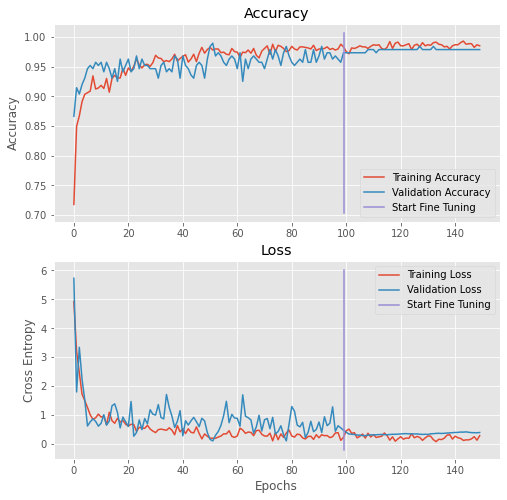

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.2443 - accuracy: 0.9609

2/5 [===========>..................] - ETA: 2s - loss: 1.1400 - accuracy: 0.9570

3/5 [=================>............] - ETA: 2s - loss: 0.9061 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 0.8890 - accuracy: 0.9688

5/5 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.9700

5/5 [==============================] - 6s 1s/step - loss: 0.8238 - accuracy: 0.9700


[0.8237907290458679, 0.9699646830558777]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9699646643109541
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       164
           1       0.98      0.98      0.98       402

    accuracy                           0.97       566
   macro avg       0.96      0.97      0.96       566
weighted avg       0.97      0.97      0.97       566



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

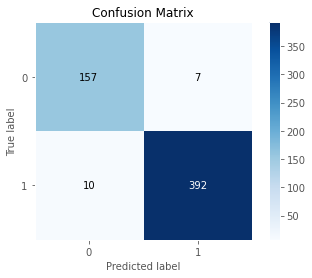

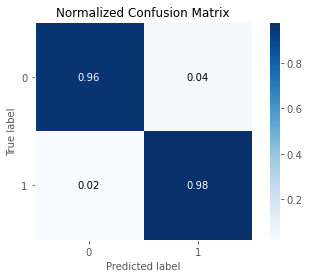

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

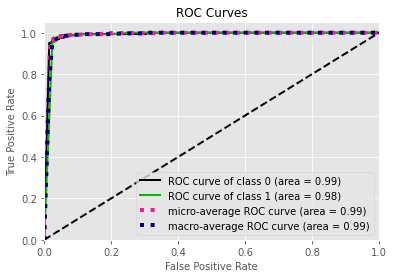

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       164
           1       0.98      0.98      0.98       402

    accuracy                           0.97       566
   macro avg       0.96      0.97      0.96       566
weighted avg       0.97      0.97      0.97       566

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.96      0.98      0.95      0.97      0.93       164
          1       0.98      0.98      0.96      0.98      0.97      0.94       402

avg / total       0.97      0.97      0.96      0.97      0.97      0.93       566

